In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import tensorflow as tf

In [2]:
with np.load('train_data_np.npz', allow_pickle=False) as npz_file_tr:
    # Load the arrays
    X_tr = npz_file_tr['features']
    y_tr = npz_file_tr['targets']

In [3]:
with np.load('test_data_np.npz', allow_pickle=False) as npz_file_te:
    # Load the arrays
    X_te = npz_file_te['features']
    y_te = npz_file_te['targets']

In [4]:
with np.load('val_data_np.npz', allow_pickle=False) as npz_file_val:
    # Load the arrays
    X_val = npz_file_val['features']
    y_val = npz_file_val['targets']

In [5]:
# Folder list
folder_list = ["bike", "car", "motorcycle", "other", "truck", "van"]

# Logistic regression

## rain and evaluate a logistic regression model (without any regularization penalty="none" and without any hyperparameters tuning).
Data must be standardized for logistic regressions and clustering, this why we are standardizing it

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the estimator
logreg = make_pipeline(StandardScaler(), LogisticRegression())

# Fit it to train data
logreg.fit(X_tr, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [30]:
# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.942


In [31]:
# Access the fitted Logistic regression estimator
logreg_1 = logreg.named_steps["logisticregression"]

In [32]:
log_coef = logreg_1.coef_
log_coef.shape

(6, 1280)

*Comment:* The accuracy of the model based on train set is excellent. Lets see it is generalize well. Each row of log_coef correspond to a category while each column corresponds to a feature in the training data.

In [26]:
log_coef_cat_0 = log_coef[0]  # Coefficients for class 0
print(log_coef_cat_0.shape)  

(1280,)


In [27]:
# Sort the coefficients in descending order
sorted_indices = np.argsort(log_coef_cat_0)[::-1]  # Indices of sorted values in descending order
sorted_values = log_coef_cat_0[sorted_indices]  # Sorted coefficients

print(sorted_values)  # Print sorted coefficients
print(sorted_indices)  # Print indices corresponding to the sorted coefficients

[ 0.05734998  0.05184404  0.04931765 ... -0.03480562 -0.03519144
 -0.04030885]
[ 801  222 1247 ... 1122  699  311]


In [28]:
# Create a DataFrame
sorted_coeff = pd.DataFrame({
    "Index": sorted_indices,
    "Values": sorted_values
})
sorted_coeff.head(10)

,Index,Values
0,801,0.057350
1,222,0.051844
2,1247,0.049318
3,1128,0.049109
4,1220,0.048996
5,1233,0.047821
6,999,0.047373
7,1199,0.047301
8,530,0.047251
9,183,0.046767


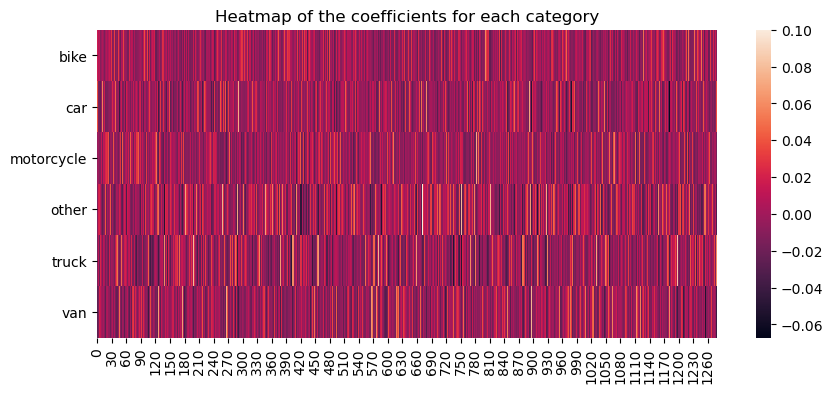

In [13]:
import seaborn as sns

plt.figure(figsize=(10, 4))
plt.title("Heatmap of the coefficients for each category")
sns.heatmap(log_coef, yticklabels=folder_list)
plt.show()

*Comments:* In the first task, we mentionned that features like 165 and 1022 should be investigated further to understand what these features represent and how they contribute to categorization. 
- We can mentionned that Van and truck share the same feature 1022. 
- In addition, Truck, car and other share the same high feature 165.

## Set an “l2” regularization and tune the regularization strength parameter of the model with cross-validated grid-search.

We will use the softmax regression model, also known as multinomial logistic regression, which is the generalization of the logistic regression model to multiple classes. We can control the weight of the penalisation term L2 with the C parameter
Among the solvers supporting the l2 regularization parameter, we can see "lbfgs", "saga", "newton-cg". Liblinear is not supporting l2 regularization

To tune the hyperparameter with cross validated grid search, we are splitting the train set into a smaller train and validation ones (in our case, that will be 10 cross folds). The idea is to use the small train set to fit the different estimators with varying C values, use the validation one to compare them and finally, pick the best performing value C*. Finally we refit the tuned estimator to the entire train set and compute a final classification report with the test set.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

In [68]:
# I Create the pipeline using softmax regression ("multinomial") and lbfgs solver.
logreg_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logreg_1", LogisticRegression(multi_class="multinomial", solver="lbfgs")),
    ]
)

In [69]:
# Create cross-validation object with 10 cross folds and various regularization strenght
grid = {"logreg_1__C": np.logspace(-10, 6, num=10)} 
grid_cv = GridSearchCV(logreg_pipe, grid, cv=10, return_train_score=True, n_jobs=-1)

In [70]:
# Fit estimator with training values
grid_cv.fit(X_tr, y_tr)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg_1',
                                        LogisticRegression(multi_class='multinomial'))]),
             n_jobs=-1,
             param_grid={'logreg_1__C': array([1.00000000e-10, 5.99484250e-09, 3.59381366e-07, 2.15443469e-05,
       1.29154967e-03, 7.74263683e-02, 4.64158883e+00, 2.78255940e+02,
       1.66810054e+04, 1.00000000e+06])},
             return_train_score=True)

In [72]:
# Display the best regularization strenght
grid_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg_1',
                 LogisticRegression(C=4.641588833612772,
                                    multi_class='multinomial'))])

*Comments:* The best regularization l2 parameter estimated after 10 cross folds and various c values is 4,64.

## Report the result of cross-validated grid-search as a dataframe and interpret the result. In particular, briefly explain what are the mean_train_score, mean_test_score, std_train_score and std_test_score:
- How are they obtained?
- What do they measure?
- Do the training and validation curves indicate overfitting?

In [73]:

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_logreg_1__C",
]
cv_results[cols].sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logreg_1__C
6,0.917857,0.027894,1.000000,0.000000,4.641589
5,0.914286,0.032733,1.000000,0.000000,0.077426
7,0.914286,0.032733,1.000000,0.000000,278.25594
8,0.910714,0.036596,1.000000,0.000000,16681.005372
9,0.910714,0.036596,1.000000,0.000000,1000000.0
4,0.903571,0.035892,0.990873,0.002541,0.001292
3,0.542857,0.044607,0.569841,0.014869,0.000022
0,0.235714,0.017496,0.235714,0.001944,0.0
1,0.235714,0.017496,0.235714,0.001944,0.0
2,0.235714,0.017496,0.235714,0.001944,0.0


*Comments* Each row of the dataframe corresponds to the evaluation of a 10 folds cross-validation, where the training data is splited into 9 folds for training and 1 fold for validation. There are 10 models, trained and validated on different splits of the data. The aim is to produce a model that generalizes well.

- The mean training score represents the accuracy of the logistic regression model on the training data, while the test score reflects the accuracy of the model on the validation data. 

- The standard deviation indicates the variability in these accuracy scores. Our goal is to achieve the highest test/validation accuracy with the lowest standard deviation.

- Based on this, the 6th model on the first row shows the best result, with an L2 hyperparameter value of 4.64.


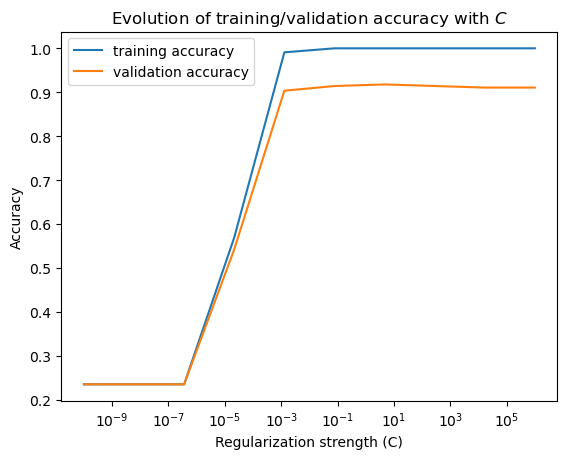

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training/validation accuracy curves
plt.semilogx(cv_results["param_logreg_1__C"], cv_results["mean_train_score"], label='training accuracy')
plt.semilogx(cv_results["param_logreg_1__C"], cv_results["mean_test_score"],  label='validation accuracy')
plt.xlabel('Regularization strength (C)')
plt.ylabel('Accuracy')
plt.title("Evolution of training/validation accuracy with $C$")
plt.legend()
plt.show()

*Comments:* The validation and training curves do not indicate overfitting, as there is an 8.2-point difference between the accuracy of the model on the training data and the validation data, which is acceptable. In addition, the model performs well on the validation data, achieving 92% accuracy with low variability in results, as evidenced by a standard deviation of 2.7 points. The model generalizes well to new data.

## Making predictions and classification report

In [ ]:
# We will make our predictions using the best estimator and the train/val sets

In [63]:
X_final = np.concatenate((X_tr, X_val.reshape(139, 1280)), axis=0) 
y_final = np.concatenate((y_tr, y_val), axis=0) 
X_final.shape, y_final.shape

((419, 1280), (419,))

In [67]:
logreg_1

LogisticRegression()

In [87]:
# Building the estimator
final_estimator = logreg_pipe.set_params(
    logreg_1__C=4.641588833612772,
    logreg_1__multi_class='multinomial',
    logreg_1__solver="lbfgs",
    logreg_1__max_iter=500
)

In [91]:
# Compute predictions with the "best_estimator_" attribute
final_estimator.fit(X_final, y_final)

y_te_pred = final_estimator.predict(X_te)

In [92]:
from sklearn.metrics import classification_report
# Classification report
print(classification_report(y_true=y_te, y_pred=y_te_pred))

              precision    recall  f1-score   support

        bike       1.00      1.00      1.00        12
         car       1.00      0.91      0.95        11
  motorcycle       1.00      1.00      1.00         9
       other       0.89      1.00      0.94         8
       truck       0.86      0.86      0.86         7
         van       0.80      0.80      0.80         5

    accuracy                           0.94        52
   macro avg       0.92      0.93      0.93        52
weighted avg       0.94      0.94      0.94        52



*Comments:* the logistic regression model indicates the best precision and recall for bikes and motocycles. Contrary to the KNN model, this model provide a very good f1 score for the other category at 86% while the score reached for cars, trucks and van is similar with previous model. Overall the score is much better with 94% of accuracy. 

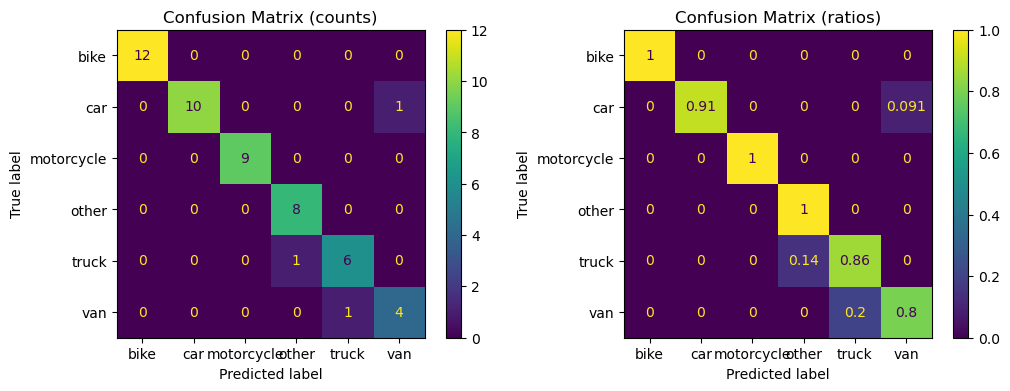

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(y_true=y_te, y_pred=y_te_pred, ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(y_true=y_te, y_pred=y_te_pred, normalize="true", ax=ax2)

plt.show()

*Comments* The confusion matrix shows that bikes, cars, motorcycles and others are very well classified. The model made several errors to classify van which were classified as car and trucks. Given the small number of vans in the datasets, it represent 20% of accuracy each. These errors is due to the wide diversity of vans based on their functions (e.g., ambulances, leisure vehicles, plumber vans). Additionally, the "other" category includes a broad range of vehicles, from scooters and buses to toys and road construction machines, further complicating classification. 

In [95]:
log_score = final_estimator.score(X_te, y_te)*100
log_score

94.23076923076923

In [97]:
#Save the score in the SQL Table 
import sqlite3

log_data = {'model': ['Logistic regression'],
        'test_accuracy': [log_score]}
log_df = pd.DataFrame(log_data)

# Save to SQLite
conn = sqlite3.connect('results.db')
log_df.to_sql('results_table', conn, if_exists='append', index=False)
conn.close()